## Install PySpark

In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


## Import libraries

In [2]:
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, DateType, DecimalType
from pyspark.sql.functions import col, when, sum, avg, row_number
from pyspark.sql.window import Window

from pyspark.sql import functions as F
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt

## Create Spark Session

In [3]:
#create session
spark = SparkSession.builder.appName("IPL Data Analysis").getOrCreate()

In [4]:
spark

## Load data

### Load Ball_by_ball data

In [5]:
ball_by_ball_schema = StructType([
    StructField("match_id", IntegerType(), True),
    StructField("over_id", IntegerType(), True),
    StructField("ball_id", IntegerType(), True),
    StructField("innings_no", IntegerType(), True),
    StructField("team_batting", StringType(), True),
    StructField("team_bowling", StringType(), True),
    StructField("striker_batting_position", IntegerType(), True),
    StructField("extra_type", StringType(), True),
    StructField("runs_scored", IntegerType(), True),
    StructField("extra_runs", IntegerType(), True),
    StructField("wides", IntegerType(), True),
    StructField("legbyes", IntegerType(), True),
    StructField("byes", IntegerType(), True),
    StructField("noballs", IntegerType(), True),
    StructField("penalty", IntegerType(), True),
    StructField("bowler_extras", IntegerType(), True),
    StructField("out_type", StringType(), True),
    StructField("caught", BooleanType(), True),
    StructField("bowled", BooleanType(), True),
    StructField("run_out", BooleanType(), True),
    StructField("lbw", BooleanType(), True),
    StructField("retired_hurt", BooleanType(), True),
    StructField("stumped", BooleanType(), True),
    StructField("caught_and_bowled", BooleanType(), True),
    StructField("hit_wicket", BooleanType(), True),
    StructField("obstructingfeild", BooleanType(), True),
    StructField("bowler_wicket", BooleanType(), True),
    StructField("match_date", DateType(), True),
    StructField("season", IntegerType(), True),
    StructField("striker", IntegerType(), True),
    StructField("non_striker", IntegerType(), True),
    StructField("bowler", IntegerType(), True),
    StructField("player_out", IntegerType(), True),
    StructField("fielders", IntegerType(), True),
    StructField("striker_match_sk", IntegerType(), True),
    StructField("strikersk", IntegerType(), True),
    StructField("nonstriker_match_sk", IntegerType(), True),
    StructField("nonstriker_sk", IntegerType(), True),
    StructField("fielder_match_sk", IntegerType(), True),
    StructField("fielder_sk", IntegerType(), True),
    StructField("bowler_match_sk", IntegerType(), True),
    StructField("bowler_sk", IntegerType(), True),
    StructField("playerout_match_sk", IntegerType(), True),
    StructField("battingteam_sk", IntegerType(), True),
    StructField("bowlingteam_sk", IntegerType(), True),
    StructField("keeper_catch", BooleanType(), True),
    StructField("player_out_sk", IntegerType(), True),
    StructField("matchdatesk", DateType(), True)
])

ball_by_ball_df = spark.read.schema(ball_by_ball_schema).format("csv").option("header","true").load("C:/Users/risha/Desktop/IPL Data Analysis/data/Ball_By_Ball.csv")

In [6]:
#Normalize values
replacements = {
    "Kolkata Knight Riders": 1,
    "Royal Challengers Bangalore": 2,
    "Chennai Super Kings": 3,
    "Kings XI Punjab": 4,
    "Rajasthan Royals": 5,
    "Delhi Daredevils": 6,
    "Mumbai Indians": 7,
    "Deccan Chargers": 8,
    "Kochi Tuskers Kerala": 9,
    "Pune Warriors": 10,
    "Sunrisers Hyderabad": 11,
    "Rising Pune Supergiants": 12,
    "Gujarat Lions": 13
}

# Create a new column with replaced values
for team_name, team_id in replacements.items():
    ball_by_ball_df = ball_by_ball_df.withColumn(
        "team_batting",
        F.when(ball_by_ball_df["team_batting"] == team_name, team_id).otherwise(ball_by_ball_df["team_batting"])
    )
    ball_by_ball_df = ball_by_ball_df.withColumn(
        "team_bowling",
        F.when(ball_by_ball_df["team_bowling"] == team_name, team_id).otherwise(ball_by_ball_df["team_bowling"])
    )

#Fix wicket column
ball_by_ball_df = ball_by_ball_df.withColumn(
    "bowler_wicket", 
    F.when(F.col("out_type") != "Not Applicable", 1).otherwise(0)
)

#Drop NULL Columns

columns_to_drop = [
    'caught', 'bowled', 'run_out', 'lbw', 'retired_hurt', 'matchdatesk','match_date',
    'stumped', 'caught_and_bowled', 'hit_wicket', 'obstructingfeild', 'keeper_catch'
]

# Drop the columns
ball_by_ball_df = ball_by_ball_df.drop(*columns_to_drop)

# ball_by_ball_df.show()
# pandas_df = ball_by_ball_df.toPandas()
# ball_by_ball_df.printSchema()

In [7]:
# distinct_values = {}
# for column in pandas_df.columns:
#     distinct_values[column] = pandas_df[column].unique()

# # Display the distinct values for each column
# for column, values in distinct_values.items():
#     print(f"Distinct values for column '{column}': {values}")

### Load Match data

In [8]:
match_schema = StructType([
    StructField("match_sk", IntegerType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("team1", StringType(), True),
    StructField("team2", StringType(), True),
    StructField("match_date", DateType(), True),
    StructField("season_year", IntegerType(), True),
    StructField("venue_name", StringType(), True),
    StructField("city_name", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("toss_winner", StringType(), True),
    StructField("match_winner", StringType(), True),
    StructField("toss_name", StringType(), True),
    StructField("win_type", StringType(), True),
    StructField("outcome_type", StringType(), True),
    StructField("manofmach", StringType(), True),
    StructField("win_margin", IntegerType(), True),
    StructField("country_id", IntegerType(), True)
])
match_df = spark.read.schema(match_schema).format("csv").option("header","true").load("C:/Users/risha/Desktop/IPL Data Analysis/data/match.csv")
match_df = match_df.withColumn(
    'win_type',
    F.when(F.col('win_type') == 'run', 'runs')  # Replace 'run' with 'runs'
     .when((F.col('win_type') == 'NA') | (F.col('win_type').isNull()), 'No Result')  # Replace 'NA' and None with 'No Result'
     .when(F.lower(F.col('win_type')) == 'no result', 'No Result')  # Standardize 'NO Result' and 'No Result'
     .otherwise(F.col('win_type'))  # Keep other values unchanged
)

match_df = match_df.withColumn(
    'toss_name',
    F.when(F.col('toss_name') == 'NA', None)  # Replace 'NA' with 'Unknown'
     .otherwise(F.lower(F.col('toss_name')))  # Convert all other values to lowercase
)
# match_df.printSchema()
pandas_match_df = match_df.toPandas()

In [9]:
distinct_values = {}
for column in pandas_match_df.columns:
    distinct_values[column] = pandas_match_df[column].unique()

# # Display the distinct values for each column
for column, values in distinct_values.items():
    print(f"Distinct values for column '{column}': {values}")

Distinct values for column 'match_sk': [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236

### Load Player Data

In [10]:
player_schema = StructType([
    StructField("player_sk", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True)
])

player_df = spark.read.schema(player_schema).format("csv").option("header","true").load("C:/Users/risha/Desktop/IPL Data Analysis/data/Player.csv")
# player_df.printSchema()
pd_player_df = player_df.toPandas()

### Load Player Match Data

In [11]:
player_match_schema = StructType([
    StructField("player_match_sk", IntegerType(), True),
    StructField("playermatch_key", DecimalType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("role_desc", StringType(), True),
    StructField("player_team", StringType(), True),
    StructField("opposit_team", StringType(), True),
    StructField("season_year", IntegerType(), True),
    StructField("is_manofthematch", BooleanType(), True),
    StructField("age_as_on_match", IntegerType(), True),
    StructField("isplayers_team_won", BooleanType(), True),
    StructField("batting_status", StringType(), True),
    StructField("bowling_status", StringType(), True),
    StructField("player_captain", StringType(), True),
    StructField("opposit_captain", StringType(), True),
    StructField("player_keeper", StringType(), True),
    StructField("opposit_keeper", StringType(), True)
])

player_match_df = spark.read.schema(player_match_schema).format("csv").option("header","true").load("C:/Users/risha/Desktop/IPL Data Analysis/data/Player_match.csv")
# player_match_df.printSchema()

In [12]:
batting_hand_replacements = {
    '�Right-hand bat': 'Right-hand bat',
    'Right-handed': 'Right-hand bat',
    '�Left-hand bat': 'Left-hand bat'
}

# Define the mappings for the 'bowling_skill' column
bowling_skill_replacements = {
    'N/A': None,
    'NULL': None,
    'Right-arm medium fast': 'Right-arm medium-fast',
    '�Right-arm fast-medium': 'Right-arm fast-medium',
    '�Left-arm fast': 'Left-arm fast',
    '�Right-arm medium-fast': 'Right-arm medium-fast',
    '�Right-arm offbreak': 'Right-arm offbreak',
    '�Legbreak': 'Legbreak'
}

# Apply replacements for 'batting_hand' column
player_match_df = player_match_df.replace(batting_hand_replacements, subset=['batting_hand'])

# Apply replacements for 'bowling_skill' column
player_match_df = player_match_df.replace(bowling_skill_replacements, subset=['bowling_skill'])

# pd_player_match_df = player_match_df.toPandas()

In [13]:
# distinct_values = {}
# for column in pd_player_match_df.columns:
#     distinct_values[column] = pd_player_match_df[column].unique()

# # Display the distinct values for each column
# for column, values in distinct_values.items():
#     print(f"Distinct values for column '{column}': {values}")

### Load Team data

In [14]:
team_schema = StructType([
    StructField("team_sk", IntegerType(), True),
    StructField("team_id", IntegerType(), True),
    StructField("team_name", StringType(), True)
])

team_df = spark.read.schema(team_schema).format("csv").option("header","true").load("C:/Users/risha/Desktop/IPL Data Analysis/data/Team.csv")
# team_df.printSchema()
# team_pandas_df = team_df.toPandas()
# print(team_pandas_df)

# 1. Team Performance Insights


## 1.1. Total Runs Scored by Each Team Across All Seasons

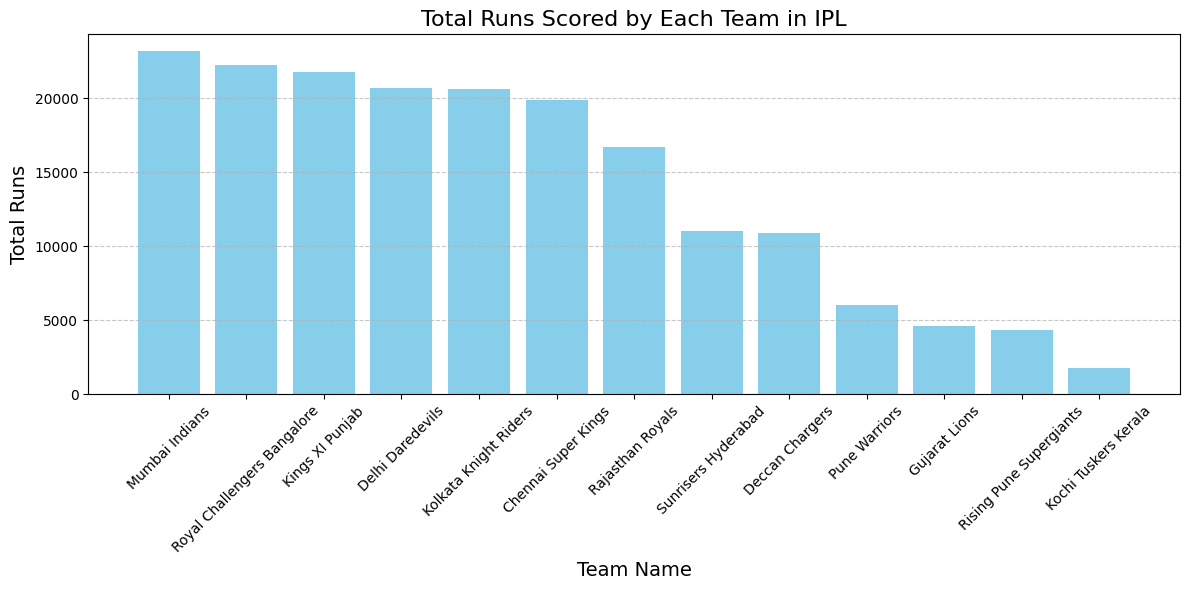

In [15]:
# Total runs scored by each team

team_runs_df = ball_by_ball_df.groupBy('battingteam_sk').agg(
    F.sum('runs_scored').alias('total_runs')
)

team_runs_with_names = team_runs_df.join(
    team_df,
    team_runs_df.battingteam_sk == team_df.team_sk,'inner').select(team_df.team_name,team_runs_df.total_runs).orderBy(F.desc('total_runs'))

# team_runs_with_names.show(30)

team_runs_pd = team_runs_with_names.toPandas()

# Step 2: Plotting
plt.figure(figsize=(12, 6))
plt.bar(team_runs_pd['team_name'], team_runs_pd['total_runs'], color='skyblue')

# Step 3: Adding Titles and Labels
plt.title('Total Runs Scored by Each Team in IPL', fontsize=16)
plt.xlabel('Team Name', fontsize=14)
plt.ylabel('Total Runs', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 4: Show the plot
plt.tight_layout()
plt.show()

## 1.2. Total Wickets Taken by Each Team Across All Seasons

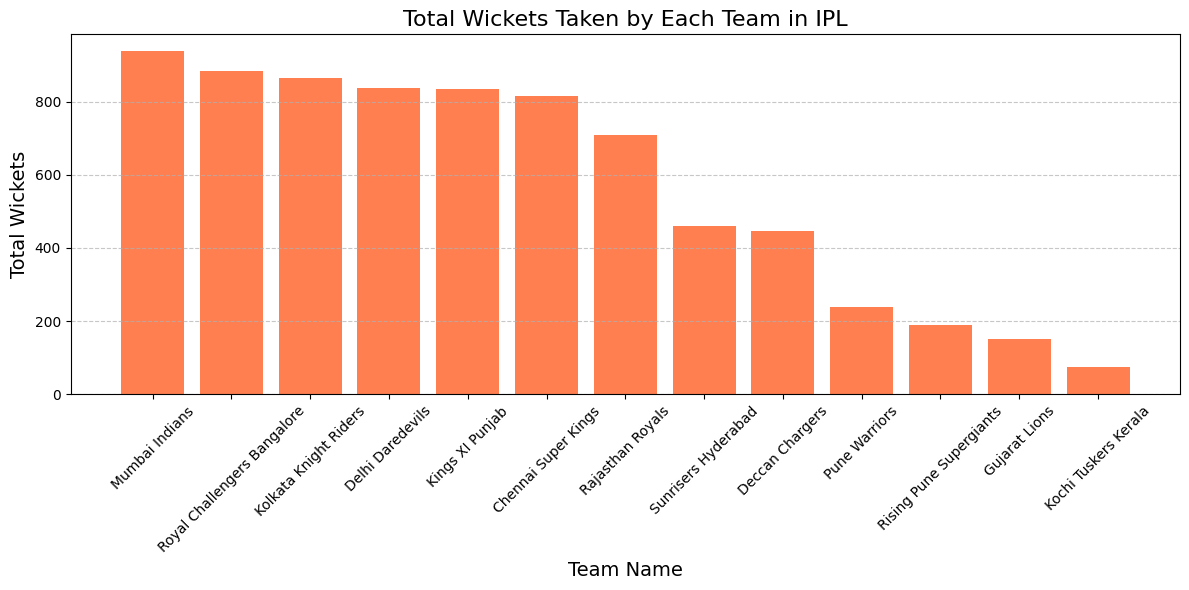

In [16]:
# Total wickets taken by each team
team_wickets_df = ball_by_ball_df.filter(ball_by_ball_df['bowler_wicket'] == 1) \
    .groupBy('bowlingteam_sk').agg(
        F.count('bowler_wicket').alias('total_wickets')
    )

# Step 2: Join with team_df to get team names
team_wickets_with_names = team_wickets_df.join(
    team_df,
    team_wickets_df.bowlingteam_sk == team_df.team_sk,
    'inner'  # You can also use 'left' if you want to keep teams even if they haven't taken any wickets
).select(
    team_df.team_name,
    team_wickets_df.total_wickets
).orderBy(F.desc('total_wickets'))

# team_wickets_with_names.show()

team_wickets_pd = team_wickets_with_names.toPandas()

# Step 2: Plotting
plt.figure(figsize=(12, 6))
plt.bar(team_wickets_pd['team_name'], team_wickets_pd['total_wickets'], color='coral')

# Step 3: Adding Titles and Labels
plt.title('Total Wickets Taken by Each Team in IPL', fontsize=16)
plt.xlabel('Team Name', fontsize=14)
plt.ylabel('Total Wickets', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 4: Show the plot
plt.tight_layout()
plt.show()

## 1.3. Most Successful Teams per Season ------------issue color

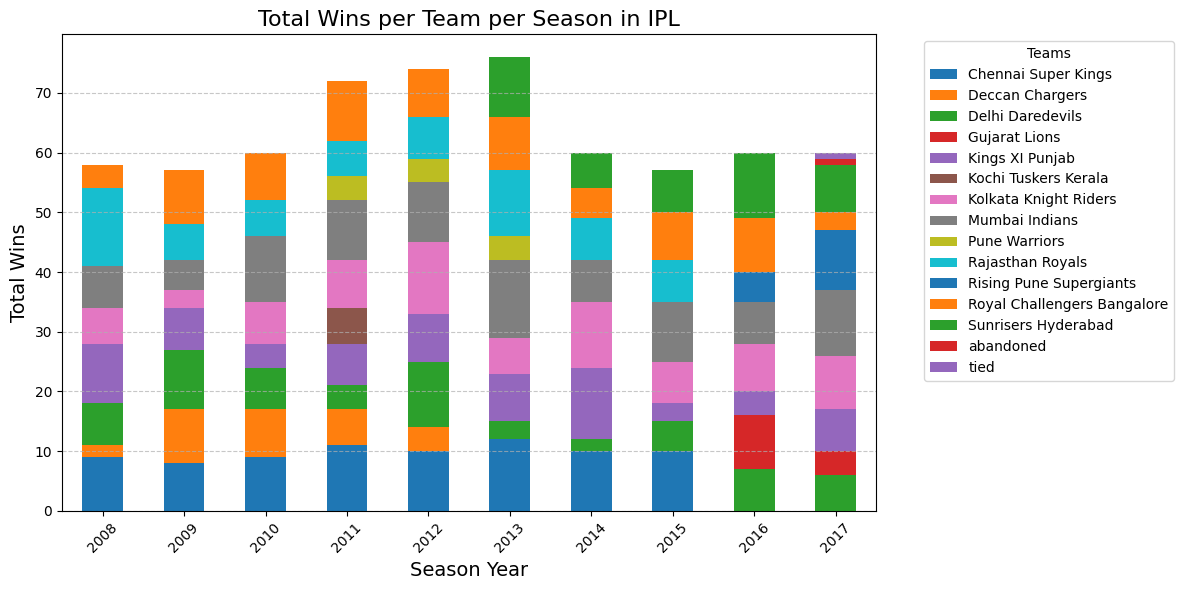

In [17]:
# Matches won by each team per season
team_wins_per_season = match_df.groupBy('match_winner', 'season_year').agg(F.count('match_id').alias('total_wins')).orderBy(F.desc('total_wins'))
# team_wins_per_season.show()

# Step 1: Convert the PySpark DataFrame to Pandas DataFrame
team_wins_per_season_pd = team_wins_per_season.toPandas()

# Step 2: Replace 'NULL' string with None (or np.nan) and drop rows with actual nulls
team_wins_per_season_pd.replace('NULL', None, inplace=True)  # or np.nan
team_wins_per_season_pd = team_wins_per_season_pd.dropna()

# Step 3: Pivot the DataFrame for better plotting
pivot_df = team_wins_per_season_pd.pivot(index='season_year', columns='match_winner', values='total_wins').fillna(0)

# Step 4: Plotting
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=plt.cm.tab10.colors)

# Step 5: Adding Titles and Labels
plt.title('Total Wins per Team per Season in IPL', fontsize=16)
plt.xlabel('Season Year', fontsize=14)
plt.ylabel('Total Wins', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Teams', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 6: Show the plot
plt.tight_layout()
plt.show()

# 2. Player Performance Insights

## 2.1. Top Run Scorers

In [23]:
!pip install seaborn

C:\Users\risha\AppData\Local\Temp\ipykernel_18452\1155914892.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player_name', y='total_runs', data=top_batsmen_pd, palette='viridis')


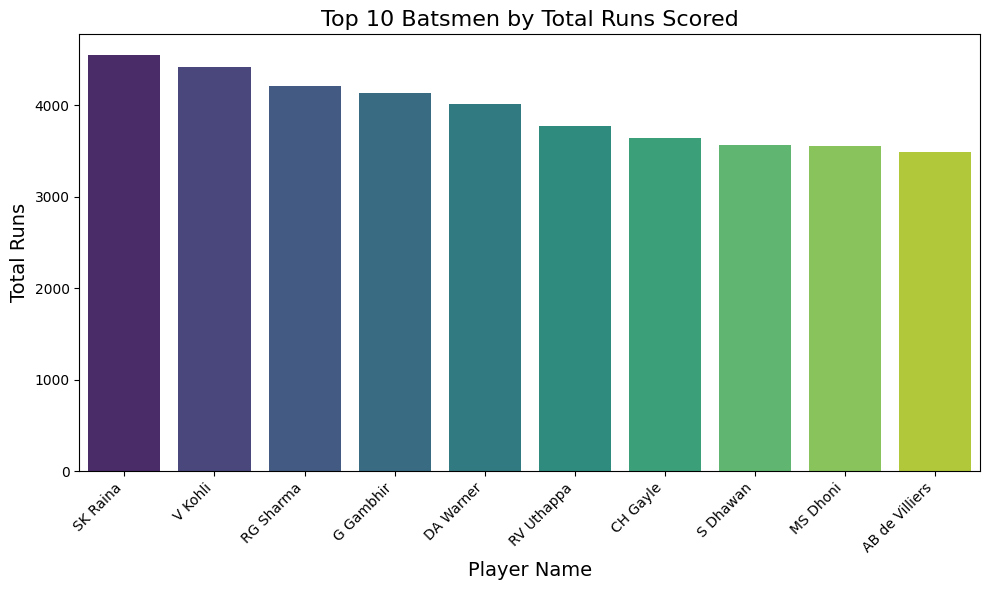

In [24]:
from pyspark.sql.functions import sum, desc

# Perform the join between ball_by_ball_df and player_df on the appropriate columns
top_batsmen = ball_by_ball_df.join(player_df, ball_by_ball_df["Striker"] == player_df["player_id"]) \
    .groupBy("player_name") \
    .agg(sum("Runs_Scored").alias("total_runs")) \
    .orderBy(desc("total_runs"))

# Convert to Pandas DataFrame for visualization
top_batsmen_pd = top_batsmen.limit(10).toPandas()

# Visualize using matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a bar plot for the top 10 batsmen
sns.barplot(x='player_name', y='total_runs', data=top_batsmen_pd, palette='viridis')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')

# Add title and labels
plt.title('Top 10 Batsmen by Total Runs Scored', fontsize=16)
plt.xlabel('Player Name', fontsize=14)
plt.ylabel('Total Runs', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


## 2.2. Top Wicket-Takers

C:\Users\risha\AppData\Local\Temp\ipykernel_18452\2070338719.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player_name', y='total_wickets', data=top_bowlers_df, palette='viridis')


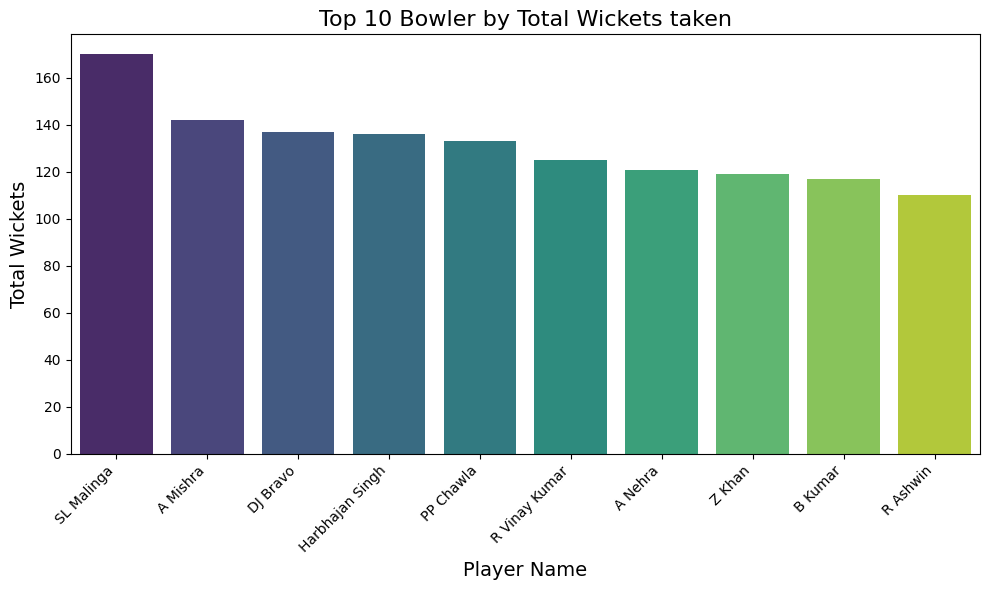

In [25]:
player_wickets = ball_by_ball_df.filter(
    ball_by_ball_df['out_type'] != 'Not Applicable'
).groupBy('bowler').agg(
    F.count('out_type').alias('total_wickets')
)

# Step 2: Join with player DataFrame to get player names
joined_df = player_wickets.join(player_df, player_wickets.bowler == player_df.player_id, how="inner")

# Step 3: Select player names and total wickets, and get top 10 players
top_bowlers_df = joined_df.select(player_df["player_name"], player_wickets["total_wickets"]) \
                           .orderBy(player_wickets["total_wickets"].desc()) \
                           .limit(10) \
                           .toPandas()

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a bar plot for the top 10 batsmen
sns.barplot(x='player_name', y='total_wickets', data=top_bowlers_df, palette='viridis')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')

# Add title and labels
plt.title('Top 10 Bowler by Total Wickets taken', fontsize=16)
plt.xlabel('Player Name', fontsize=14)
plt.ylabel('Total Wickets', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


## 2.3.  Consistency in Performance (Matches Played vs Runs/Wickets)

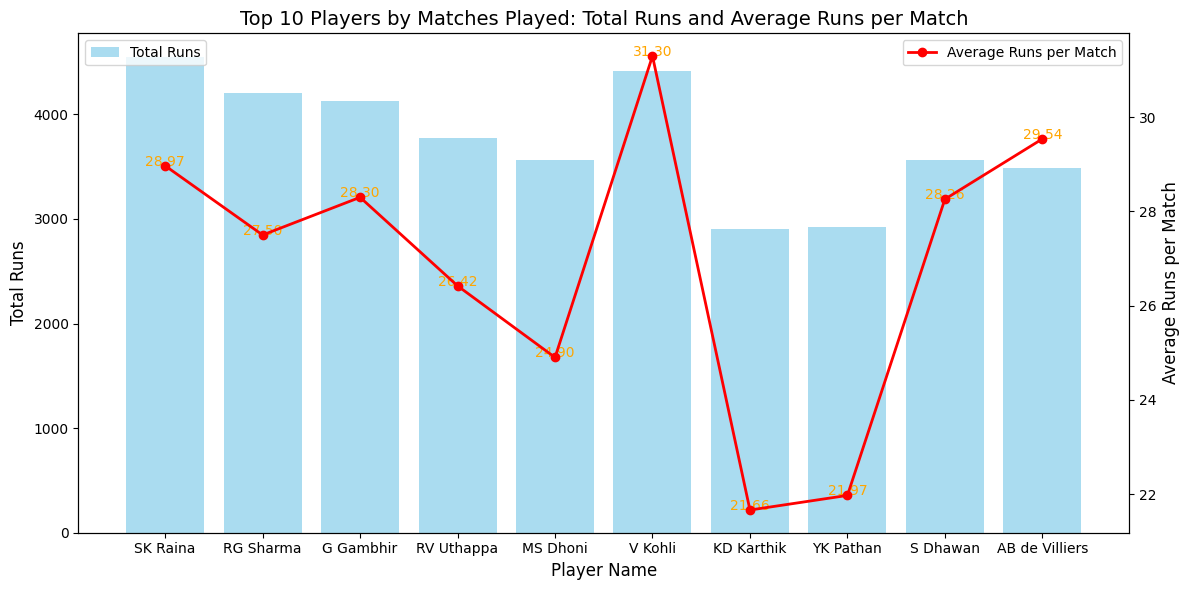

In [26]:
player_match_count = ball_by_ball_df.groupBy('striker').agg(
    F.countDistinct('match_id').alias('matches_played'),
    F.sum('runs_scored').alias('total_runs')
)

# Step 2: Join with player DataFrame to get player names
joined_df = player_match_count.join(player_df, player_match_count.striker == player_df.player_id, how='inner')

# Step 3: Select player names, matches played, and total runs
result_df = joined_df.select(player_df["player_name"], player_match_count["matches_played"], player_match_count["total_runs"]) \
                      .withColumn('average_runs_per_match', 
                                  F.format_number(
                                      F.when(player_match_count["matches_played"] > 0, 
                                              player_match_count["total_runs"] / player_match_count["matches_played"])
                                      .otherwise(0), 2)) \
                      .orderBy(player_match_count["total_runs"].desc())

# Show the results
# result_df.show()

pandas_df = result_df.toPandas()

# Step 1: Filter for top 10 players by matches played
top_10_players = pandas_df.nlargest(10, 'matches_played')

# Step 2: Set the figure size
fig, ax1 = plt.subplots(figsize=(12, 6))

# Step 3: Create a bar chart for total runs on the primary y-axis
ax1.bar(top_10_players['player_name'], top_10_players['total_runs'], 
        color='skyblue', label='Total Runs', alpha=0.7)
ax1.set_xlabel('Player Name', fontsize=12)
ax1.set_ylabel('Total Runs', fontsize=12)
ax1.tick_params(axis='y')

# Step 4: Create a secondary y-axis for average runs per match
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.plot(top_10_players['player_name'], top_10_players['average_runs_per_match'].astype(float), 
         color='red', marker='o', label='Average Runs per Match', linewidth=2, zorder=5)
ax2.set_ylabel('Average Runs per Match', fontsize=12)
ax2.tick_params(axis='y')

# Step 5: Add data labels for average runs
for index, row in top_10_players.iterrows():
    ax2.text(row['player_name'], float(row['average_runs_per_match']), 
             f"{float(row['average_runs_per_match']):.2f}", horizontalalignment='center', color='orange')

# Step 6: Set the title
plt.title('Top 10 Players by Matches Played: Total Runs and Average Runs per Match', fontsize=14)

# Step 7: Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Step 8: Show the plot
plt.tight_layout()
plt.show()



<Figure size 1600x600 with 0 Axes>

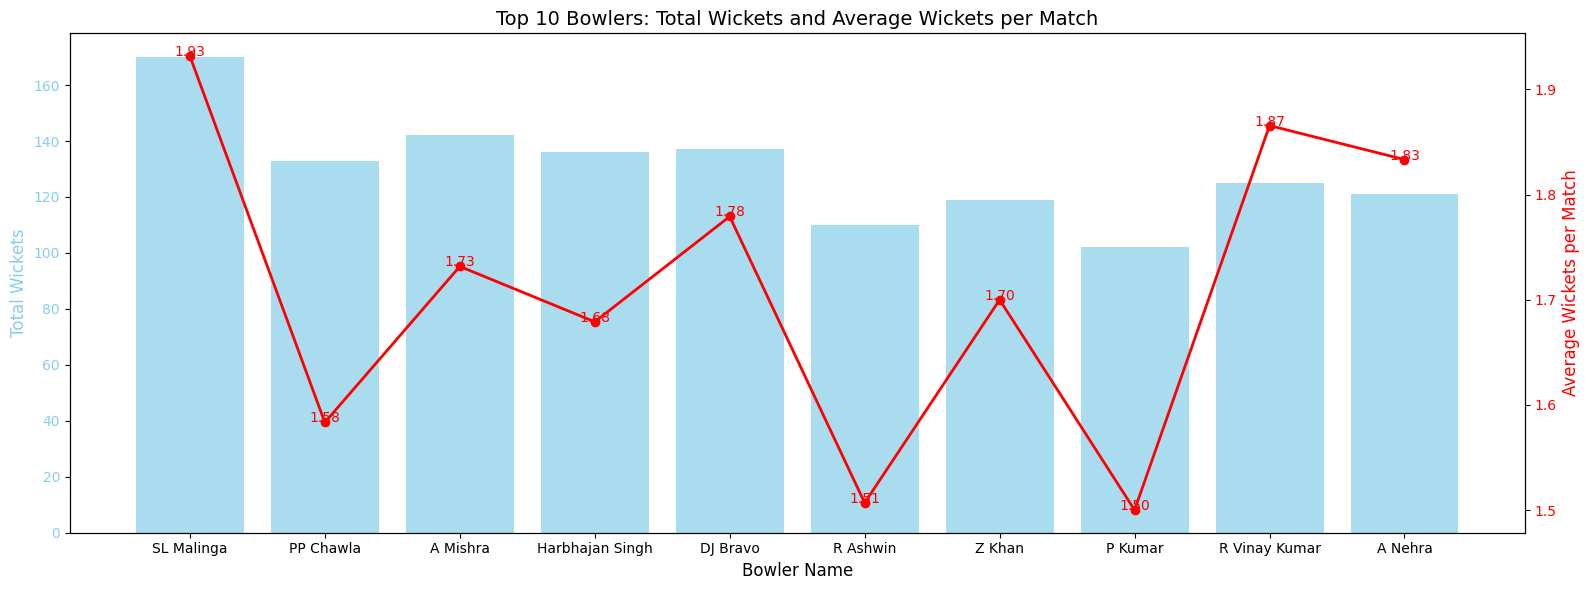

In [27]:
bowler_match_count = ball_by_ball_df.filter(ball_by_ball_df['bowler_wicket'] == True).groupBy('bowler').agg(
    F.countDistinct('match_id').alias('matches_played'),
    F.count('bowler_wicket').alias('total_wickets')
)

joined_bowler_df = bowler_match_count.join(player_df, bowler_match_count.bowler == player_df.player_id, how='inner')


result_bowler_df = joined_bowler_df.select(
    player_df["player_name"], 
    bowler_match_count["matches_played"], 
    bowler_match_count["total_wickets"]
).withColumn(
    'average_wickets_per_match', 
    F.when(bowler_match_count["matches_played"] > 0, 
           bowler_match_count["total_wickets"] / bowler_match_count["matches_played"])
    .otherwise(0)
).orderBy(bowler_match_count["total_wickets"].desc())

# Show the results
# result_bowler_df.show()

pandas_bowler_df = result_bowler_df.toPandas()

# Filter for top 10 bowlers by matches played
top_10_bowlers = pandas_bowler_df.nlargest(10, 'matches_played')

# Set the figure size (increase the width)
plt.figure(figsize=(16, 6))  # Increase the width to 16
fig, ax1 = plt.subplots(figsize=(16, 6))  # Increase the width to 16

# Bar chart for total wickets
color = 'skyblue'
ax1.set_xlabel('Bowler Name', fontsize=12)
ax1.set_ylabel('Total Wickets', fontsize=12, color=color)
ax1.bar(top_10_bowlers['player_name'], top_10_bowlers['total_wickets'], color=color, alpha=0.7, label='Total Wickets')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for average wickets per match
ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('Average Wickets per Match', fontsize=12, color=color)
ax2.plot(top_10_bowlers['player_name'], top_10_bowlers['average_wickets_per_match'], color=color, marker='o', linewidth=2, label='Average Wickets per Match')
ax2.tick_params(axis='y', labelcolor=color)

# Add data labels for average wickets per match
for index, row in top_10_bowlers.iterrows():
    ax2.text(row['player_name'], row['average_wickets_per_match'], 
             f"{row['average_wickets_per_match']:.2f}", horizontalalignment='center', color=color)

# Set the title
plt.title('Top 10 Bowlers: Total Wickets and Average Wickets per Match', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

# 3. Match and Toss Insights

## 3.1. Toss Decision Impact on Match Outcome

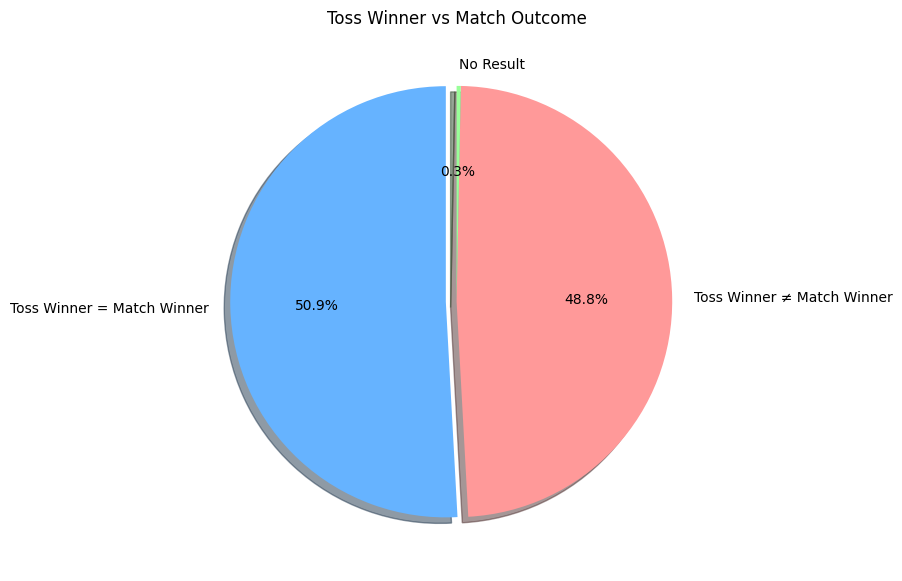

In [28]:
# Correct the condition for toss_match_loss and toss_match_noresult cases
toss_match_wins = match_df.filter(match_df['toss_winner'] == match_df['match_winner']).count() / match_df.count() * 100

# Toss winner did not win, excluding tied or abandoned matches
toss_match_loss = match_df.filter((match_df['toss_winner'] != match_df['match_winner']) & 
                                  (match_df['match_winner'] != 'tied') & 
                                  (match_df['match_winner'] != 'abandoned')).count() / match_df.count() * 100

# No result (match tied or abandoned)
toss_match_noresult = match_df.filter((match_df['match_winner'] == 'tied') | 
                                      (match_df['match_winner'] == 'abandoned')).count() / match_df.count() * 100

# Prepare data for visualization
labels = ['Toss Winner = Match Winner', 'Toss Winner ≠ Match Winner', 'No Result']
sizes = [toss_match_wins, toss_match_loss, toss_match_noresult]
colors = ['#66b3ff', '#ff9999', '#99ff99']  # Three colors for three categories

# Create pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.05, 0, 0), shadow=True)
plt.title('Toss Winner vs Match Outcome')
plt.show()


## 3.2. Match Outcomes (Win by Runs or Wickets)

+---------+---------+
| win_type|win_count|
+---------+---------+
|  wickets|      339|
|     runs|      287|
|      Tie|        6|
|No Result|        5|
+---------+---------+



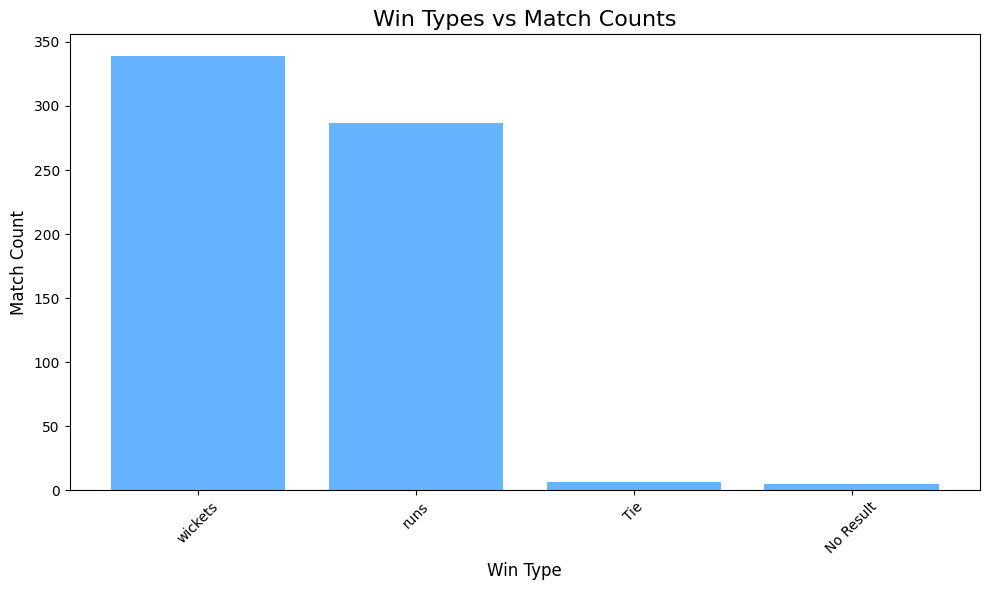

In [29]:
# Win by runs or wickets
win_type_count = match_df.groupBy('win_type').agg(F.count('match_id').alias('win_count')).orderBy(F.desc('win_count'))
win_type_count.show()
# Convert PySpark DataFrame to Pandas for visualization
win_type_count_pd = win_type_count.toPandas()

# Extract the win types and their counts
win_types = win_type_count_pd['win_type']
win_counts = win_type_count_pd['win_count']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(win_types, win_counts, color='#66b3ff')

# Add titles and labels
plt.title('Win Types vs Match Counts', fontsize=16)
plt.xlabel('Win Type', fontsize=12)
plt.ylabel('Match Count', fontsize=12)

# Rotate x-axis labels if necessary for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

# 4. Season Insights

## 4.1. Season-wise Total Runs   -------------------------remove

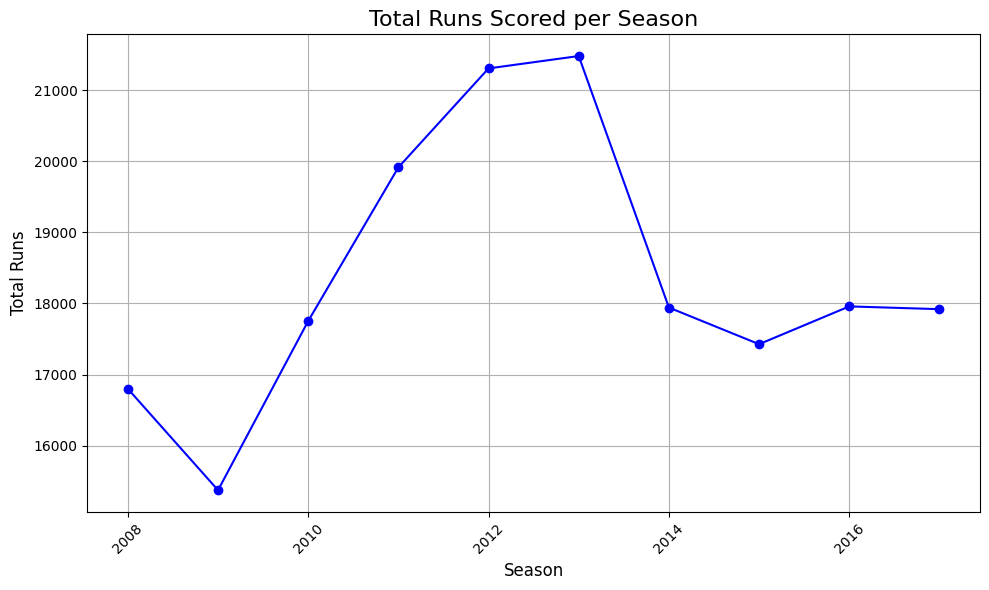

In [30]:
season_runs = ball_by_ball_df.groupBy('season').agg(F.sum('runs_scored').alias('total_runs')).orderBy(F.asc('season'))
# season_runs.show()

season_runs_pd = season_runs.toPandas()

# Extract seasons and total runs
seasons = season_runs_pd['season']
total_runs = season_runs_pd['total_runs']

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(seasons, total_runs, marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title('Total Runs Scored per Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Total Runs', fontsize=12)

# Add grid and improve layout
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

## 4.2. Season-wise Total Wickets----------------------remove

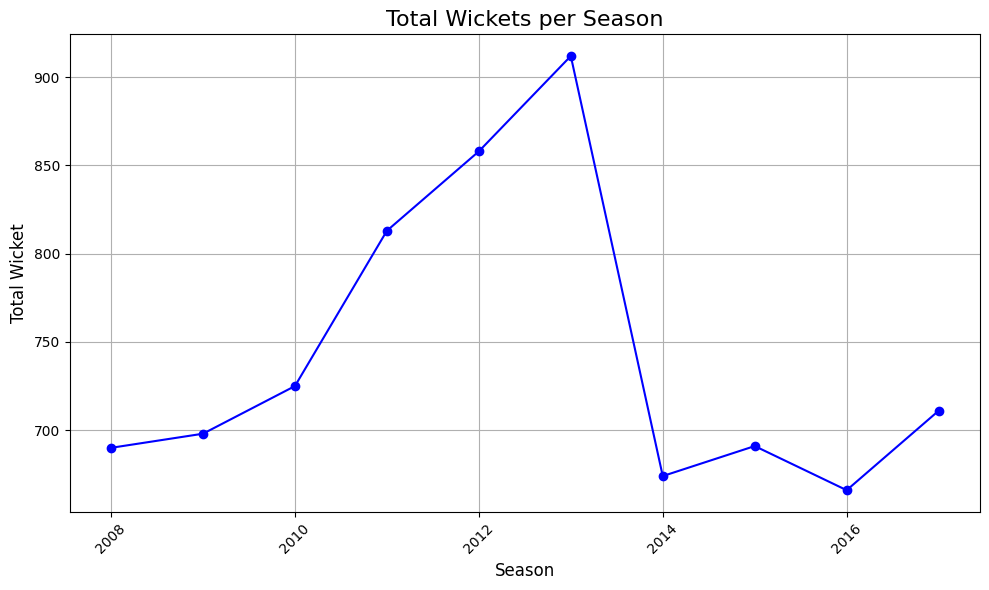

In [31]:
# Total wickets taken per season
season_wickets = ball_by_ball_df.filter(ball_by_ball_df['bowler_wicket'] == True).groupBy('season').agg(F.count('bowler_wicket').alias('total_wickets')).orderBy(F.asc('season'))
# season_wickets.show()

season_wickets_pd = season_wickets.toPandas()

# Extract seasons and total runs
seasons = season_wickets_pd['season']
total_wickets = season_wickets_pd['total_wickets']

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(seasons, total_wickets, marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title('Total Wickets per Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Total Wicket', fontsize=12)

# Add grid and improve layout
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

# 5. Venue and City Insights

## 5.1. Most Popular Venues for IPL Matches

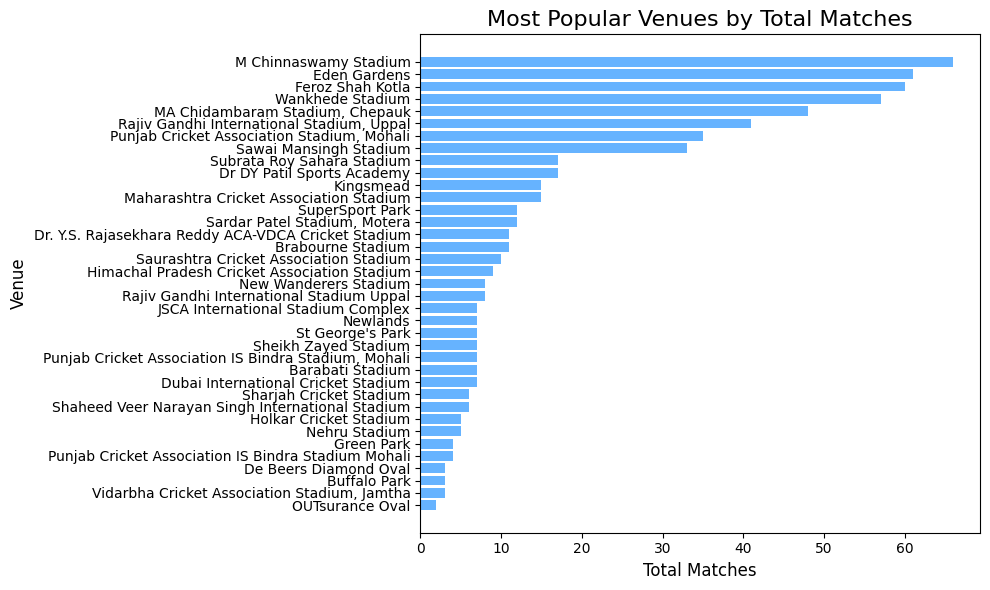

In [32]:
# Most popular venues
venue_count = match_df.groupBy('venue_name').agg(F.count('match_id').alias('total_matches')).orderBy(F.asc('total_matches'))
venue_count = venue_count.filter(venue_count['venue_name'] != 'NULL')
# venue_count.show()

venue_count_pd = venue_count.toPandas()

# Extract venues and total matches
venues = venue_count_pd['venue_name']
total_matches = venue_count_pd['total_matches']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(venues, total_matches, color='#66b3ff')

# Add titles and labels
plt.title('Most Popular Venues by Total Matches', fontsize=16)
plt.xlabel('Total Matches', fontsize=12)
plt.ylabel('Venue', fontsize=12)

# Improve layout and readability
plt.tight_layout()
plt.show()

## 5.2. Most Popular Cities for IPL Matches

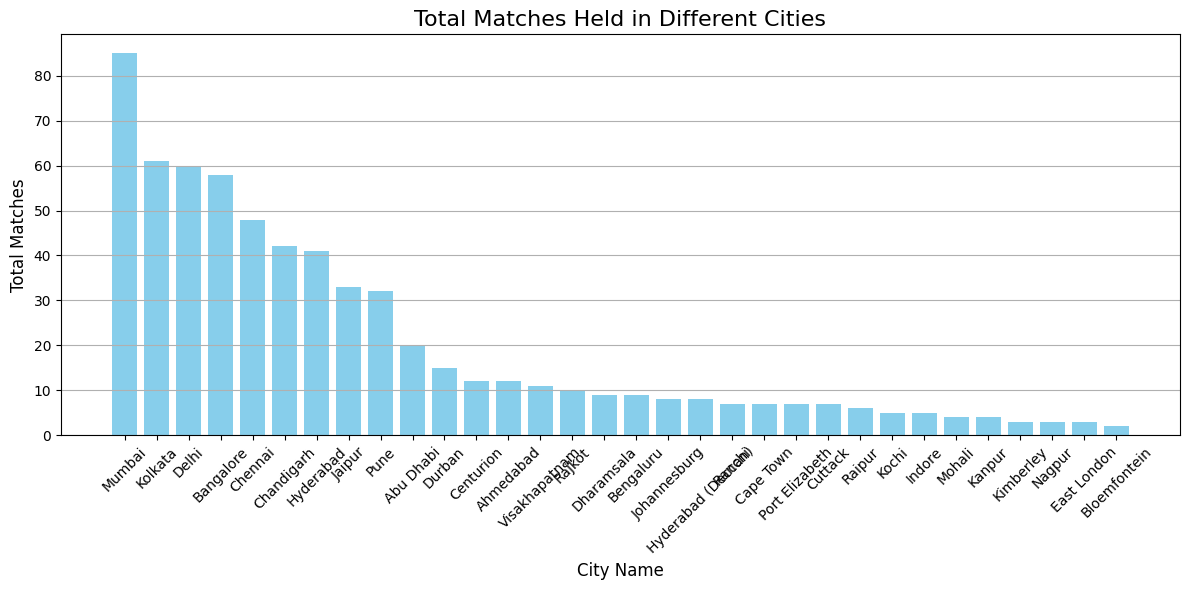

In [33]:
# Most popular cities
city_count = match_df.groupBy('city_name').agg(F.count('match_id').alias('total_matches')).orderBy(F.desc('total_matches'))
# city_count.show()

city_count_pd = city_count.toPandas()

# Step 1: Sort the DataFrame for better visualization
city_count_pd = city_count_pd.sort_values(by='total_matches', ascending=False)

# Step 2: Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(city_count_pd['city_name'], city_count_pd['total_matches'], color='skyblue')
plt.xticks(rotation=45)
plt.title('Total Matches Held in Different Cities', fontsize=16)
plt.xlabel('City Name', fontsize=12)
plt.ylabel('Total Matches', fontsize=12)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

# 6. Fielding and Extras Insights

## 6.1. Top Players Involved in Run Outs

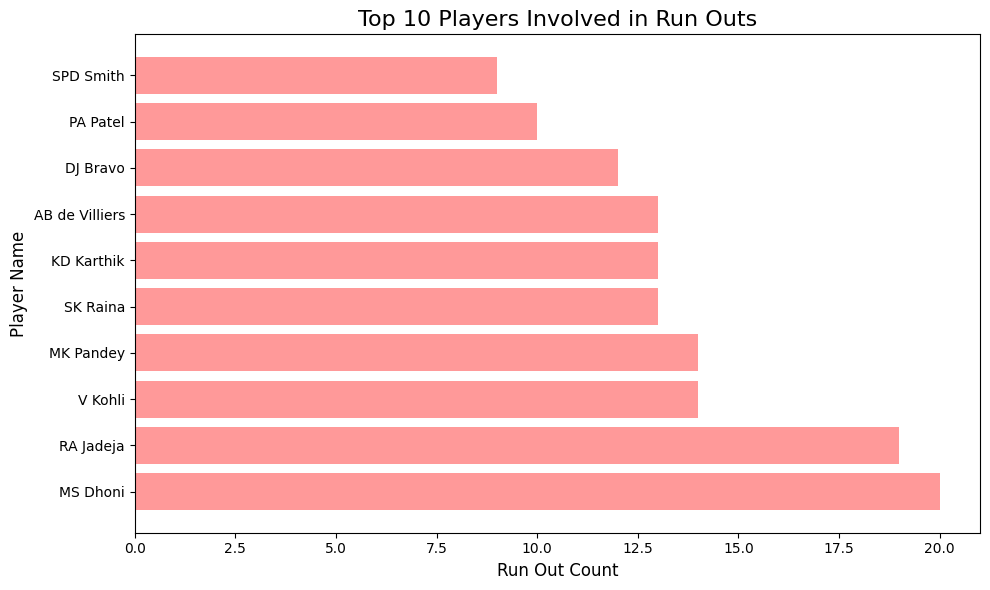

In [34]:
# Players involved in run outs
run_outs = ball_by_ball_df.filter(ball_by_ball_df['out_type'] == 'run out') \
                          .groupBy('fielder_sk') \
                          .agg(F.count('out_type').alias('run_out_count')) \
                          .orderBy(F.desc('run_out_count'))
# run_outs.show()

run_outs_with_names = run_outs.join(player_df, run_outs['fielder_sk'] == player_df['player_sk'], 'inner') \
                                .select(player_df['player_name'], run_outs['run_out_count'])

# Get the top 10 players involved in run outs
top_run_outs_with_names = run_outs_with_names.orderBy(F.desc('run_out_count')).limit(10)

# Convert the top run outs DataFrame to Pandas for visualization
top_run_outs_pd = top_run_outs_with_names.toPandas()

# Extract player names and run out counts
player_names = top_run_outs_pd['player_name']
run_out_counts = top_run_outs_pd['run_out_count']

# Create a bar chart for the top 10 players
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
plt.barh(player_names, run_out_counts, color='#ff9999')

# Add titles and labels
plt.title('Top 10 Players Involved in Run Outs', fontsize=16)
plt.xlabel('Run Out Count', fontsize=12)
plt.ylabel('Player Name', fontsize=12)

# Improve layout and readability
plt.tight_layout()
plt.show()

## 6.2. Total Extras per Match and Season------------------review


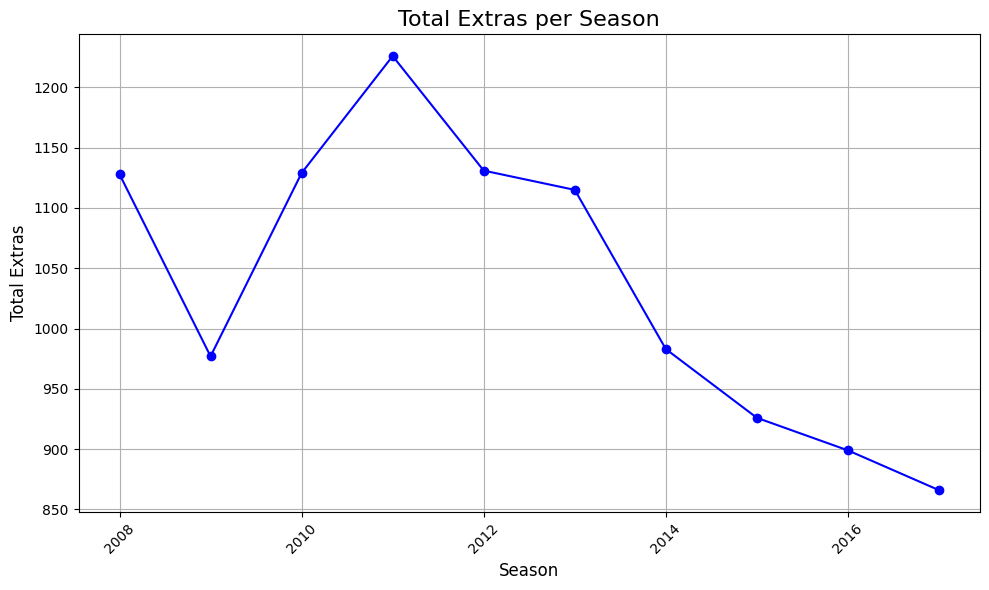

In [35]:
# Total extras per match and season
extras = ball_by_ball_df.withColumn('total_extras', F.col('wides') + F.col('noballs') + F.col('byes') + F.col('legbyes') + F.col('penalty'))
season_extras = extras.groupBy('season').agg(F.sum('total_extras').alias('total_extras')).orderBy(F.asc('season'))
# season_extras.show()

season_extras_pd = season_extras.toPandas()

# Extract seasons and total extras
seasons = season_extras_pd['season']
total_extras = season_extras_pd['total_extras']

# Create a line plot
plt.figure(figsize=(10, 6))  # Set figure size for better readability
plt.plot(seasons, total_extras, marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title('Total Extras per Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Total Extras', fontsize=12)

# Add grid and improve layout
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()


# 7. Key Factors for Player Selection

## 7.1. Player Batting Performance
### Factor: Runs scored, Strike Rate, and Consistency
### Key Metric: Total runs scored, average runs per match, and strike rate.
### Insight: Top-performing batsmen with consistent runs across matches and seasons should be prioritized. Players who have a high strike rate, especially in key overs (powerplay and death overs), will be more valuable in aggressive game situations.


In [36]:
# Calculate total runs, average runs, and strike rate for each batsman
batsman_performance = ball_by_ball_df.groupBy('striker').agg(
    F.sum('runs_scored').alias('total_runs'),
    F.countDistinct('match_id').alias('matches_played'),
    (F.sum('runs_scored') / F.countDistinct('match_id')).alias('avg_runs_per_match'),
    ((F.sum('runs_scored') / F.count('ball_id'))*100).alias('strike_rate')
).orderBy(F.desc('total_runs'))
batsman_performance.show()




+-------+----------+--------------+------------------+------------------+
|striker|total_runs|matches_played|avg_runs_per_match|       strike_rate|
+-------+----------+--------------+------------------+------------------+
|     21|      4548|           157| 28.96815286624204|134.99554764024933|
|      8|      4413|           141| 31.29787234042553|126.30223239839727|
|     57|      4207|           153| 27.49673202614379|128.49725106902872|
|     40|      4132|           146|28.301369863013697|120.36120011651616|
|    187|      4014|           114| 35.21052631578947| 138.3184011026878|
|     46|      3778|           143| 26.41958041958042|127.63513513513513|
|    162|      3647|           100|             36.47|144.09324377716317|
|     42|      3561|           126|28.261904761904763|118.50249584026622|
|     20|      3560|           143|24.895104895104897| 132.8358208955224|
|    110|      3486|           118| 29.54237288135593|145.12905911740216|
|     85|      3057|           105|29.

### Steps to Create Ratings and Visualize:
Define a Rating Formula: For example, you might want to give weights to each parameter. Here’s a simple formula:

    Rating=0.5×avg_runs_per_match+0.3×strike_rate+0.2×total_runs
    Rating=0.5×avg_runs_per_match+0.3×strike_rate+0.2×total_runs
    



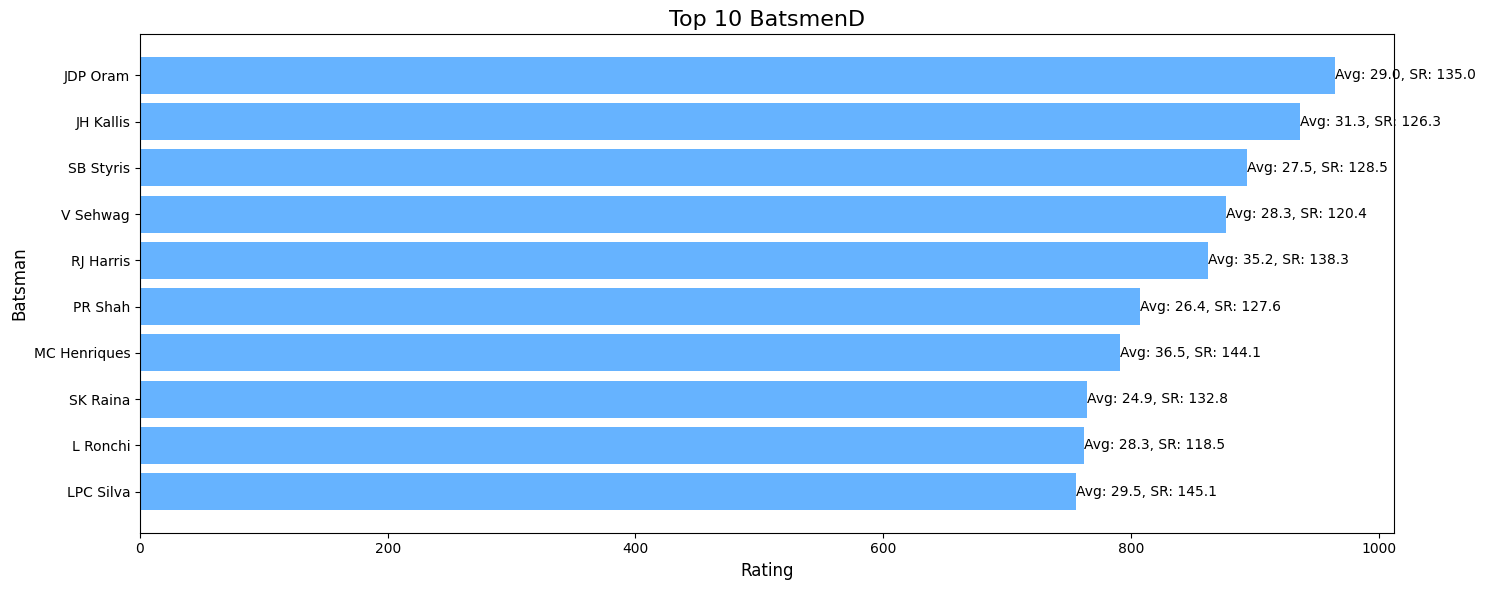

In [37]:
import numpy as np

# Step 1: Generate ratings based on the defined formula
batsman_performance_with_rating = batsman_performance.withColumn(
    'rating',
    0.5 * F.col('avg_runs_per_match') + 
    0.3 * F.col('strike_rate') + 
    0.2 * F.col('total_runs')
)

# Step 2: Get the top 10 batsmen based on the rating
top_batsmen = batsman_performance_with_rating.orderBy(F.desc('rating')).limit(10)

# Step 3: Join with players_df to get player names
top_batsmen_with_names = top_batsmen.join(player_df, top_batsmen['striker'] == player_df['player_sk'], 'inner') \
                                     .select(player_df['player_name'], top_batsmen['avg_runs_per_match'], top_batsmen['strike_rate'], top_batsmen['rating'])

# Step 4: Convert to Pandas for visualization
top_batsmen_pd = top_batsmen_with_names.toPandas()
top_batsmen_pd = top_batsmen_pd.sort_values(by='rating', ascending=True)

# Extract player names, ratings, average runs, and strike rates
player_names = top_batsmen_pd['player_name']
ratings = top_batsmen_pd['rating']
avg_runs = top_batsmen_pd['avg_runs_per_match']
strike_rates = top_batsmen_pd['strike_rate']

# Step 5: Create a bar chart for the ratings sorted by rating
plt.figure(figsize=(15, 6))  # Adjust figure size for better readability
bars = plt.barh(player_names, ratings, color='#66b3ff')

# Annotate each bar with Avg and SR
for bar, avg, sr in zip(bars, avg_runs, strike_rates):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'Avg: {avg:.1f}, SR: {sr:.1f}', 
             va='center', ha='left', fontsize=10)

# Add titles and labels
plt.title('Top 10 BatsmenD', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Batsman', fontsize=12)

# Improve layout and readability
plt.tight_layout()

# Display the plot
plt.show()


### Strategy:
Select batsmen with high average runs and strike rate, especially when facing strong bowling line-ups.
Consider left-hand and right-hand combinations based on bowler type (e.g., right-arm off-spinners vs. left-hand batsmen)


## 7.2. Player Bowling Performance
### Factor: Wickets taken, Economy Rate, and Wicket-Taking Ability in Crucial Overs
### Key Metric: Total wickets, average wickets per match, and economy rate.
### Insight: Bowlers with the ability to take wickets in key overs (powerplay and death overs) are critical for success. A low economy rate, especially in death overs, can prevent opponents from accelerating their run rate.

In [ ]:
# Calculate total wickets, average wickets per match, and economy rate for each bowler
bowler_performance = ball_by_ball_df.filter(ball_by_ball_df['bowler_wicket'] == True).groupBy('bowler').agg(
    F.count('bowler_wicket').alias('total_wickets'),
    (F.count('bowler_wicket') / F.countDistinct('match_id')).alias('avg_wickets_per_match'),
    (F.sum('runs_scored') / F.count('ball_id')).alias('economy_rate')
).orderBy(F.desc('total_wickets'))
bowler_performance.show()


In [ ]:
# Step 1: Calculate total runs given and overs bowled by each bowler
bowler_performance = ball_by_ball_df.groupBy('bowler').agg(
    F.count('bowler_wicket').alias('total_wickets'),
    (F.count('bowler_wicket') / F.countDistinct('match_id')).alias('avg_wickets_per_match'),
    F.sum('runs_scored').alias('total_runs'),  # Total runs given by the bowler
    F.countDistinct('over_id').alias('total_overs')  # Total overs bowled
)

# Step 2: Calculate the economy rate
bowler_performance = bowler_performance.withColumn('economy_rate', 
    F.when(F.col('total_overs') > 0, F.col('total_runs') / F.col('total_overs')).otherwise(0)
)

# Step 3: Round the economy rate to 2 decimal places
bowler_performance = bowler_performance.withColumn('economy_rate', F.round('economy_rate', 2))

# Step 4: Order by total wickets
bowler_performance = bowler_performance.orderBy(F.desc('total_wickets'))

# Show the result
bowler_performance.show()

In [ ]:
# Calculate total wickets, average wickets per match, and economy rate for each bowler
bowler_performance = ball_by_ball_df.filter(ball_by_ball_df['bowler_wicket'] == True).groupBy('bowler').agg(
    F.count('bowler_wicket').alias('total_wickets'),
    (F.count('bowler_wicket') / F.countDistinct('match_id')).alias('avg_wickets_per_match'),
    (F.sum('runs_scored') / (F.countDistinct('over_id') / 6)).alias('economy_rate')  # Calculate economy rate
).orderBy(F.desc('total_wickets'))

# Round average wickets and economy rate to 2 decimal places
bowler_performance = bowler_performance.withColumn('avg_wickets_per_match', F.round('avg_wickets_per_match', 2)) \
                                         .withColumn('economy_rate', F.round('economy_rate', 2))

# Show the results
bowler_performance.show()


### Strategy:
Select bowlers with high wicket-taking ability in powerplay and death overs.
Focus on economy rate when selecting bowlers for matches with smaller boundaries or high-scoring venues.


## 7.3. Player Fielding and Catching Ability
### Factor: Impact in Run Outs, Catches, and Fielding Positions
### Key Metric: Number of run-outs, catches, and fielding positions.
### Insight: Strong fielders, particularly those who specialize in difficult positions (e.g., inner circle, boundary), can save critical runs and contribute to breaking partnerships through run-outs and catches.

In [ ]:
# Identify top fielders based on run-outs and catches
fielder_performance = ball_by_ball_df.filter((ball_by_ball_df['out_type'] == 'caught') | (ball_by_ball_df['out_type'] == 'run out')) \
    .groupBy('fielder_sk') \
    .agg(
        F.sum(F.when(ball_by_ball_df['out_type'] == 'caught', 1).otherwise(0)).alias('total_catches'),
        F.sum(F.when(ball_by_ball_df['out_type'] == 'run out', 1).otherwise(0)).alias('total_runouts')
    ).orderBy(F.desc('total_catches'))

fielder_performance.show()

### Strategy:
Prioritize players with strong fielding skills, particularly in high-pressure matches.
Use players with good fielding abilities in the deep or infield for teams with aggressive batsmen.


## 7.4. Match and Opponent-Specific Strategy
### Factor: Player Performance Against Specific Opponents and in Different Conditions
### Key Metric: Player’s historical performance against specific teams, conditions (home/away), and in different venues.
### Insight: Some players perform better against specific opponents or under certain conditions (e.g., spin-friendly or pace-friendly pitches). Analyzing this historical data can help optimize team selection based on the venue, pitch type, and opposition.

In [ ]:
# Player performance against specific opponents
player_opponent_performance = player_match_df.groupBy('player_name', 'opposit_team').agg(
    F.sum(F.col('isplayers_team_won').cast('int')).alias('wins_against_opponent'),  # Ensure boolean is cast to int for summation
    F.sum(F.col('is_manofthematch').cast('int')).alias('player_of_match_awards')  # Ensure boolean is cast to int for summation
).orderBy(F.desc('wins_against_opponent'))

player_opponent_performance.show()

### Strategy:
Select players with historically strong performances against specific opponents.
Consider match location (home/away) and player adaptability to pitch conditions.


## 7.5. Player Fitness and Availability------------age wise peeyush notebook
### Factor: Fitness, Recent Form, and Age
### Key Metric: Player’s recent form, age, and fitness records.
### Insight: While player performance is critical, their fitness and availability can affect long-term performance, especially in high-intensity tournaments. Younger players or those with better fitness might be more reliable over long seasons.


### Strategy:
Rotate players to prevent injuries and fatigue, ensuring a fresh lineup for critical matches.
Consider younger players or recently performing players who are in form, especially if they have had fewer injuries.


In [21]:
ball_by_ball_df.createOrReplaceTempView("ball_by_ball")
match_df.createOrReplaceTempView("match")
player_df.createOrReplaceTempView("player")
player_match_df.createOrReplaceTempView("player_match")
team_df.createOrReplaceTempView("team")

In [22]:
top_scoring_batsmen_per_season = spark.sql("""
WITH PlayerRunsPerSeason AS (
    SELECT
        p.player_name,
        m.season_year,
        SUM(b.runs_scored) AS total_runs,
        ROW_NUMBER() OVER (PARTITION BY m.season_year ORDER BY SUM(b.runs_scored) DESC) AS rank
    FROM ball_by_ball b
    JOIN match m ON b.match_id = m.match_id
    JOIN player_match pm ON m.match_id = pm.match_id AND b.striker = pm.player_id
    JOIN player p ON p.player_id = pm.player_id
    GROUP BY p.player_name, m.season_year
)
SELECT
    player_name,
    season_year,
    total_runs
FROM PlayerRunsPerSeason
WHERE rank = 1
ORDER BY season_year;

""")
top_scoring_batsmen_per_season.show(30)

+---------------+-----------+----------+
|    player_name|season_year|total_runs|
+---------------+-----------+----------+
|       SE Marsh|       2008|       616|
|      G Gambhir|       2008|       534|
|  ST Jayasuriya|       2008|       514|
|      SR Watson|       2008|       468|
|       GC Smith|       2008|       441|
|   AC Gilchrist|       2008|       436|
|      YK Pathan|       2008|       435|
|       SK Raina|       2008|       421|
|       MS Dhoni|       2008|       414|
|       V Sehwag|       2008|       406|
|      RG Sharma|       2008|       404|
|       R Dravid|       2008|       371|
|     SC Ganguly|       2008|       349|
|       S Dhawan|       2008|       340|
|     RV Uthappa|       2008|       320|
|  KC Sangakkara|       2008|       320|
|      DJ Hussey|       2008|       319|
|    SA Asnodkar|       2008|       311|
|       PA Patel|       2008|       302|
|   Yuvraj Singh|       2008|       299|
|Y Venugopal Rao|       2008|       288|
|      JA Morkel

In [ ]:
economical_bowlers_powerplay = spark.sql("""
SELECT
p.player_name,
AVG(b.runs_scored) AS avg_runs_per_ball,
COUNT(b.bowler_wicket) AS total_wickets
FROM ball_by_ball b
JOIN player_match pm ON b.match_id = pm.match_id AND b.bowler = pm.player_id
JOIN player p ON pm.player_id = p.player_id
WHERE b.over_id <= 6
GROUP BY p.player_name
HAVING COUNT(*) >= 1
ORDER BY avg_runs_per_ball, total_wickets DESC
""")
economical_bowlers_powerplay.show()


In [ ]:
# Execute SQL Query
scores_by_venue = spark.sql("""
SELECT venue_name, AVG(total_runs) AS average_score, MAX(total_runs) AS highest_score
FROM (
    SELECT ball_by_ball.match_id, match.venue_name, SUM(runs_scored) AS total_runs
    FROM ball_by_ball
    JOIN match ON ball_by_ball.match_id = match.match_id
    GROUP BY ball_by_ball.match_id, match.venue_name
)
GROUP BY venue_name
ORDER BY average_score DESC
""")
# Convert to Pandas DataFrame
scores_by_venue_pd = scores_by_venue.toPandas()

# Plot using Matplotlib
plt.figure(figsize=(14, 8))

# Create horizontal bar chart
plt.barh(scores_by_venue_pd['venue_name'], scores_by_venue_pd['average_score'], color='#66b3ff')

# Add title and labels
plt.title('Distribution of Scores by Venue', fontsize=16)
plt.xlabel('Average Score', fontsize=12)
plt.ylabel('Venue', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
# Execute SQL Query
team_toss_win_performance = spark.sql("""
SELECT team1, COUNT(*) AS matches_played, SUM(CASE WHEN toss_winner = match_winner THEN 1 ELSE 0 END) AS wins_after_toss
FROM match
WHERE toss_winner = team1
GROUP BY team1
ORDER BY wins_after_toss DESC
""")
team_toss_win_pd = team_toss_win_performance.toPandas()

# Plot using Matplotlib
plt.figure(figsize=(12, 8))

# Create horizontal bar chart
plt.barh(team_toss_win_pd['team1'], team_toss_win_pd['wins_after_toss'], color='#66b3ff')

# Add title and labels
plt.title('Team Performance After Winning Toss', fontsize=16)
plt.xlabel('Wins After Winning Toss', fontsize=12)
plt.ylabel('Team', fontsize=12)

# Improve layout and readability
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# Filter for the first 6 overs (powerplay)
powerplay_df = ball_by_ball_df.filter(ball_by_ball_df.Over_id <= 6)

# Calculate total runs scored in powerplay for each team
team_powerplay_scores = powerplay_df.groupBy("Match_id", "Team_Batting") \
    .agg(F.sum("Runs_Scored").alias("powerplay_runs")) \
    .orderBy(F.desc("powerplay_runs"))

# Show the result
team_powerplay_scores.show(10)


In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, count, desc

# Filter for players scoring more than 50 runs in an inning
fifties_hundreds = ball_by_ball_df.groupBy("Match_id", "Striker") \
    .agg(F.sum("Runs_Scored").alias("total_runs")) \
    .filter(col("total_runs") >= 50)

# Count how many 50s each player has
fifties = fifties_hundreds.filter((col("total_runs") >= 50) & (col("total_runs") < 100)) \
    .groupBy("Striker").agg(count("*").alias("fifties")) \
    .orderBy(desc("fifties"))

# Count how many 100s each player has
hundreds = fifties_hundreds.filter(col("total_runs") >= 100) \
    .groupBy("Striker").agg(count("*").alias("hundreds")) \
    .orderBy(desc("hundreds"))

# Show the results
fifties.show(10)
hundreds.show(10)

In [ ]:
# Assuming there's a 'home_team' and 'venue' in the dataset for analysis
home_advantage = match_df.withColumn("is_home_win", match_df["match_winner"] == match_df["team1"]).groupBy("is_home_win").count()
home_advantage.show()